# Финальный проект - снижение производственных расходов.

## Описание и цель
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
    
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.
    
    
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
    
    
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.
    
    
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая предскажет конечную температуру стали.
    
    
Для построения модели предоставлены данные о процессе изготовления стали . 

## Разведывательный анализ данных
### Загрузка файлов

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

rdm = 80523

In [2]:
#список файлов
list_df = {'df_arc':'data_arc_new.csv',
           'df_bulk':'data_bulk_new.csv',
           'df_bulk_t':'data_bulk_time_new.csv',
           'df_gas':'data_gas_new.csv',
           'df_temp':'data_temp_new.csv',
           'df_wire':'data_wire_new.csv',
           'df_wire_t':'data_wire_time_new.csv'}
#пути для чтения
pth1 = '/datasets/'
pth2 = '/home/dmitrii/Документы/FS/'

#читаем файл с сайта или с компа в отдельную переменную 
if all([os.path.exists(pth1 + x) for x in list_df.values()]):
    df_arc = pd.read_csv(pth1 + list_df['df_arc'])
    df_bulk = pd.read_csv(pth1 + list_df['df_bulk'])
    df_bulk_t = pd.read_csv(pth1 + list_df['df_bulk_t'])
    df_gas = pd.read_csv(pth1 + list_df['df_gas'])
    df_temp = pd.read_csv(pth1 + list_df['df_temp'])
    df_wire = pd.read_csv(pth1 + list_df['df_wire'])
    df_wire_t = pd.read_csv(pth1 + list_df['df_wire_t'])
    print('Файлы успешно прочитаны с сетевой директории')

elif all([os.path.exists(pth2 + x) for x in list_df.values()]):
    df_arc = pd.read_csv(pth2 + list_df['df_arc'])
    df_bulk = pd.read_csv(pth2 + list_df['df_bulk'])
    df_bulk_t = pd.read_csv(pth2 + list_df['df_bulk_t'])
    df_gas = pd.read_csv(pth2 + list_df['df_gas'])
    df_temp = pd.read_csv(pth2 + list_df['df_temp'])
    df_wire = pd.read_csv(pth2 + list_df['df_wire'])
    df_wire_t = pd.read_csv(pth2 + list_df['df_wire_t'])
    print('Файлы успешно прочитаны с локальной директории')
else:
    print('Директория со всеми файлами не найдена')

Файлы успешно прочитаны с сетевой директории


### Данные об электродах
Датафрейм представляет из себя информацию о времени начала и конца работы, а так же мощности работающих электродов, которые предназначены для нагрева расплава. Мощность разделена на две составляющие - активная(участвующая в работе) и реактивная(не участвует в нагреве, возвращается к источнику). 

In [3]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
print(df_arc.info())
df_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Датафрейм содержит 14876 значений без пропусков. Формат даты не приведен в соответствующий тип данных. Анализируя статистику датафрейма видно, что имеется выброс в колонке с реактивной мощностью. Датафрейм годится для анализа после приведения типа даты к требуемой и устранения выброса. 

### Данные об объеме сыпучих материалов

In [5]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датафрейм представляет собой записи о легирующих элементах ,поданных в зону плавления . Большое количество NaN элементов означает отсутствие подачи. Корректно заменить эти элементы на нуль. 

In [6]:
print(df_bulk.info())
df_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


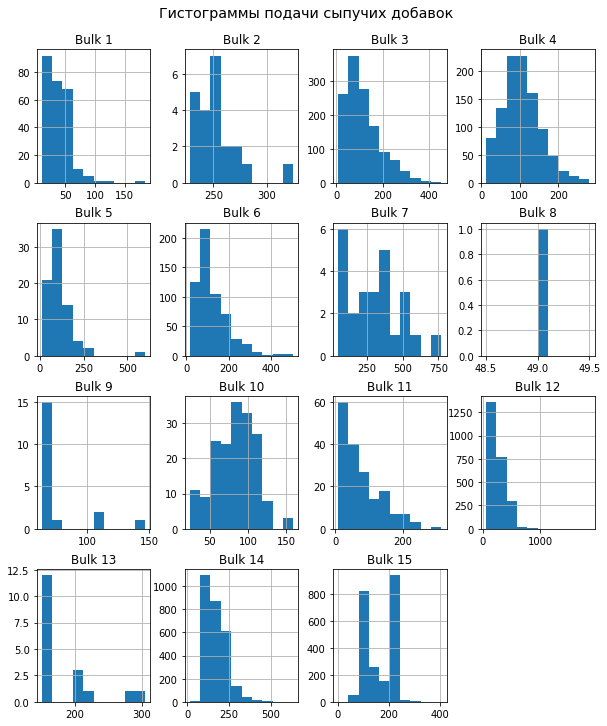

In [7]:
df_bulk.hist(column=list(df_bulk.columns)[1:]
             ,figsize=(10,12));
plt.suptitle('Гистограммы подачи сыпучих добавок',y=0.93
             , ha='center', fontsize='x-large')
plt.show()

Анализ показывает правильные типов колонок. Явных выбросов в данных не наблюдается, кроме колонок Bulk 12, Bulk 14, Bulk15, где верхнее значение требует уточнения. Bulk 8 имеет лишь 1 значение, что мало для для обучения модели. Данную колонку имеет смысл удалить по результатам консультации с бизнесом.   

### Данные о времени подачи сыпучих материалов

In [8]:
df_bulk_t.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [9]:
df_bulk_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Датафрейм представляет собой дату загрузки материалов в стальной расплав. Тип данных желательно привести к date. Важно, что эта таблица связана напрямую с таблицей об объеме подачи материалов. Необходимо проверить, что все данные одной таблицы связаны с другой. 

In [10]:
tab1 = df_bulk_t.isna() # ненулевые значения в таблице df_bulk_t
tab2 = df_bulk.isna() # ненулевые значения в таблице df_bulk
tab1.equals(tab2) #проверяем их соответствие

True

Данные в таблицах заполнены соответствующим образом.

### Данные о продувке газом. 
Для перемешивания легирующих элементов и защиты от окисления с воздухом используется продувка расплава инертными газами. Информация о величине расхода инертного газа представлена ниже.  

In [11]:
print(df_gas.info())
df_gas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


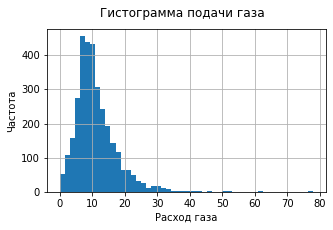

In [12]:
df_gas['Газ 1'].hist(figsize=(5,3),bins=50)
plt.suptitle('Гистограмма подачи газа',y=0.98, ha='center', fontsize='large')
plt.xlabel('Расход газа')
plt.ylabel('Частота')
plt.show()

Имеется очень аномально длинный хвост справа. В остальном данные подходят для анализа. 

### Данные о температуре. 
Основным показателем при выплавке стали является её температура. Вместе с тем контроль температуры требуется производить с высокой точностью, что является нетривиальной задачей. Температура плавления стали зависит от марки стали варьируется от 1450 С до 1535 С град.

In [13]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [14]:
print(df_temp.info())
df_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


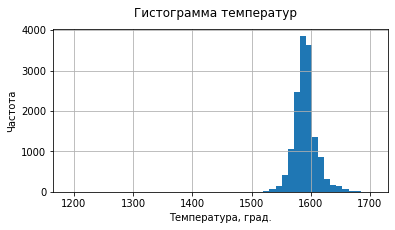

In [15]:
df_temp['Температура'].hist(bins=50,figsize=(6,3))
plt.suptitle('Гистограмма температур',y=0.98, ha='center', fontsize='large')
plt.xlabel('Температура, град.')
plt.ylabel('Частота')
plt.show()

Для некоторой части замеров не хватает данных о температуре. Температура находится в очень узком диапазоне - нижний квантиль - 1580 С, верхний - 1599 С. Температуры ниже 1450 для нашего сплава можно удалить. 

### Данные о подаче проволоки

Датафрейм представляет собой записи о легирующих элементах ,поданных в зону плавления в виде проволоки. Большое количество NaN элементов означает отсутствие подачи. Корректно заменить эти элементы на нуль. 

In [16]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(df_wire.info())
df_wire.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


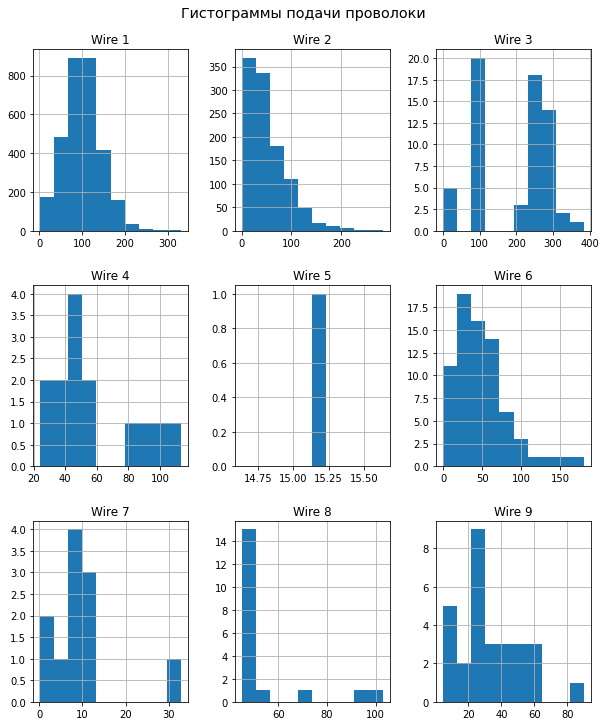

In [18]:
df_wire.hist(column=list(df_wire.columns)[1:]
             ,figsize=(10,12));
plt.suptitle('Гистограммы подачи проволоки',y=0.93
             , ha='center', fontsize='x-large')
plt.show()

Анализ показывает правильные типов колонок. Явных выбросов в данных не наблюдается. Wire 5 имеет лишь 1 значение, что мало для для обучения модели. Данную колонку имеет смысл удалить по результатам консультации с бизнесом.  

### Данные о времени подаче проволоки

In [19]:
df_wire_t.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_wire_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Датафрейм представляет собой дату загрузки проволочных материалов. Тип данных желательно привести к date. Важно, что эта таблица связана напрямую с таблицей об объеме загрузки проволочных материалов. Необходимо проверить, что все данные одной таблицы связаны с другой. 

In [21]:
tab1 = df_wire_t.isna() # ненулевые значения в таблице df_bulk_t
tab2 = df_wire.isna() # ненулевые значения в таблице df_bulk
tab1.equals(tab2) #проверяем их соответствие

True

Данные в таблицах заполнены соответствующим образом.

## Подготовка датасетов
### Обработка данных о мощности электродов
Приведем названия к одному стилистическому оформлению путем переименования их. Затем преобразуем типы столбцов с датой к соответствующему формату. Вычислим время работы нагревательных стержней в секундах. Чтобы узнать вложенную в расплав энергию вычислим произведение активной мощности на время работы. Реактивная мощность не играет роли в нагреве стали, поэтому учитываться не будет. 

In [22]:
# переименуем столбцы
df_arc.rename(columns={'Начало нагрева дугой':'start_heat',
                    'Конец нагрева дугой':'end_heat',
                    'Активная мощность':'act_power',
                    'Реактивная мощность':'react_power'},
                     errors='ignore',inplace=True)
# приводим формат к типу datetime:
df_arc['start_heat'] = pd.to_datetime(df_arc['start_heat']
                                           ,format='%Y-%m-%dT%H:%M:%S')
df_arc['end_heat'] = pd.to_datetime(df_arc['end_heat']
                                           ,format='%Y-%m-%dT%H:%M:%S')
# вычисляем дельту времени работы нагревателей:
df_arc['delta'] = df_arc['end_heat'] - df_arc['start_heat']
df_arc['delta'] = df_arc['delta'].dt.seconds

# вычисляем вложенную в расплав мощность:
df_arc['income_power'] = df_arc['delta'] * df_arc['act_power']

df_arc.tail(3)

,key,start_heat,end_heat,act_power,react_power,delta,income_power
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,30.225219
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,81,31.513617


Физически на конечную температуру расплава помимо вложенной энергии влияет продолжительность изготовления партии стали. Для вычисления суммарного времени итерации возьмем разницу времени первого и последнего включения стержней в секундах.

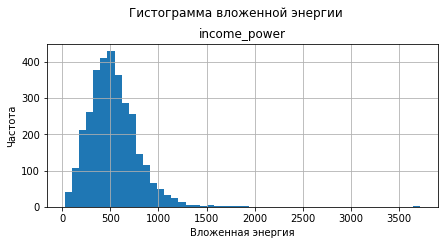

In [23]:
# агрегирующие функции и агрегируемые столбцы:
aggreg = {'income_power': np.sum}
col_pivot = ['income_power'] 
# сводная таблица:
df_energy = pd.pivot_table(df_arc,values=col_pivot,index='key',aggfunc=aggreg).reset_index()

df_energy.hist(column=list(df_energy.columns)[1:], bins=50, figsize=(7,3));
plt.suptitle('Гистограмма вложенной энергии',y=1.05, ha='center', fontsize='large')
plt.xlabel('Вложенная энергия')
plt.ylabel('Частота')
plt.show()

### Обработка данных об объёме и времени подачи сыпучих элементов 
Из предварительного анализа решено удалить столбец Bulk 8, т.к. в нем только один экземпляр, что мало для обучения и тестирования.


Пропущенные значения заполняем нулями. 

В ходе анализа решено отказаться от обработки датафрейма с временем загрузки легирующих элементов, т.к. динамические процессы не будут моделироваться в модели. 

In [24]:
print(f'Количество строк {df_bulk.shape[0]}. Количество колонок {df_bulk.shape[1]}.')
df_bulk.head(3)

Количество строк 3129. Количество колонок 16.


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [25]:
# удаляем столбец с единственным примером:
df_bulk = df_bulk.drop(columns='Bulk 8',axis=1,errors='ignore')
    
# заполняем пропуски нулями:
df_bulk.fillna(value=0,inplace=True)

In [26]:
print(f'Количество строк {df_bulk.shape[0]}. Количество колонок {df_bulk.shape[1]}.')
df_bulk.head(3)

Количество строк 3129. Количество колонок 15.


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


### Обработка данных о газе
Приведем оформление колонок к одному стилю. Согласно предварительному анализу других преобразований не требуется. 

In [27]:
print(f'Количество строк {df_gas.shape[0]}. Количество колонок {df_gas.shape[1]}.')
df_gas.head(3)

Количество строк 3239. Количество колонок 2.


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [28]:
df_gas.rename(columns={'Газ 1':'gas'}, errors='ignore',inplace=True)
df_gas.head(3)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793


### Обработка данных о температуре
Для удобства приведем названия столбцов к одному стилистическому оформлению.    

In [29]:
print(f'Количество строк {df_temp.shape[0]}. Количество колонок {df_temp.shape[1]}.')
df_temp.head(2)

Количество строк 18092. Количество колонок 3.


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


In [30]:
#переименовываем столбцы:
df_temp.rename(columns={'Время замера':'time_measure_first',
                    'Температура':'temp_start'},
                     errors='ignore',inplace=True)
df_temp.head(2)

,key,time_measure_first,temp_start
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


Согласно предварительному анализу будут выброшены партии, где температура хоть в одном замере была ниже 1450 С. Так же будут выброшены партии, где замеры температуры пропущены. Для построения модели требуется начальная и конечная температуры для одной итерации, значит в партии должно быть минимум два замера. Не подходящие под эти требования партии не войдут в финальный датафрейм температуры. 

In [31]:
# создаем столбцы для учета конечной температуры и количества замеров:
df_temp['temp_end'] = df_temp['temp_start'].copy()
df_temp['key_counts'] = df_temp['key'].copy()
# конвертируем в формат datetime  и создаем дополнительный столбец:
df_temp['time_measure_first'] = pd.to_datetime(df_temp['time_measure_first'],format='%Y-%m-%dT%H:%M:%S')
df_temp['time_measure_end'] = df_temp['time_measure_first'].copy()
#собираем ключи партий и удаляем партии, где температура была хоть раз ниже 1450С:
key_small_t = df_temp[df_temp['temp_start']<1450]['key'].values
df_temp = df_temp.query('key not in @key_small_t')
#собираем ключи партий и удаляем партии, где были пропуски замеров:
key_null_t = df_temp[df_temp['temp_start'].isna()]['key'].values
df_temp = df_temp.query('key not in @key_null_t')

Перед дальнейшей обработкой следует отметить, что при моделировании нам будет известна только начальная температура. Конечную температуру необходимо будет предсказывать. Поэтому начальная температура будет признаком обучения, а конечная температура партии - целевой переменной. 

Дополнительно создадим признак:'delta_iter' - общее время итерации. Он вычисляется как разница первого и последнего замера в секундах.  

In [32]:
# создаем сводную таблицу: 
aggreg = {'temp_start': 'first', 'temp_end':'last', 
          'time_measure_first':'first', 'time_measure_end':'last', 'key_counts':'count' }
col_pivot = ['temp_start','temp_end','time_measure_first','time_measure_end','key_counts']
df_temp_fin = pd.pivot_table(df_temp, values=col_pivot, index='key',aggfunc=aggreg)\
            .reset_index()
# проходят только те партии, где количество замеров больше 1:
df_temp_fin = df_temp_fin.query('key_counts>1')
# вычисляем длительность партии: 
df_temp_fin['delta_iter'] = (df_temp_fin['time_measure_end'] - df_temp_fin['time_measure_first']).dt.seconds

# удаляем  лишние столбцы:
df_temp_fin.drop(['time_measure_first','time_measure_end','key_counts'],axis=1,inplace=True,errors='ignore')

print(f'Количество строк {df_temp_fin.shape[0]}. Количество колонок {df_temp_fin.shape[1]}.')
df_temp_fin.tail(3)

Количество строк 2471. Количество колонок 4.


,key,temp_end,temp_start,delta_iter
2470,2497,1589.0,1571.0,962
2471,2498,1594.0,1591.0,1520
2472,2499,1603.0,1569.0,1537


### Данные по проволоке

Обработку начнем с заполнения пропусков нулями. Во многих колонках количество значений недостаточно много, что может оказать негативное действие на результат. Сильное преобладание нулевых значений делает гистограмму неинформативной. 

In [33]:
print(f'Количество строк {df_wire.shape[0]}. Количество колонок {df_wire.shape[1]}.')
df_wire.head(3)

Количество строк 3081. Количество колонок 10.


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# заполняем нулями пропуски
df_wire.fillna(value=0,inplace=True)
# удаляем столбцы
df_wire.drop(['Wire 5','Wire 7'], axis=1, inplace = True, errors = 'ignore')
print(f'Количество строк {df_wire.shape[0]}. Количество колонок {df_wire.shape[1]}.')
df_wire.head(3)

Количество строк 3081. Количество колонок 8.


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 8,Wire 9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0


### Объединение датасетов

Для анализа модели соединим разрозненные датасеты в один. Ключом для соединения будет колонка key - номер партии. 

Количество строк 2325. Количество колонок 26.


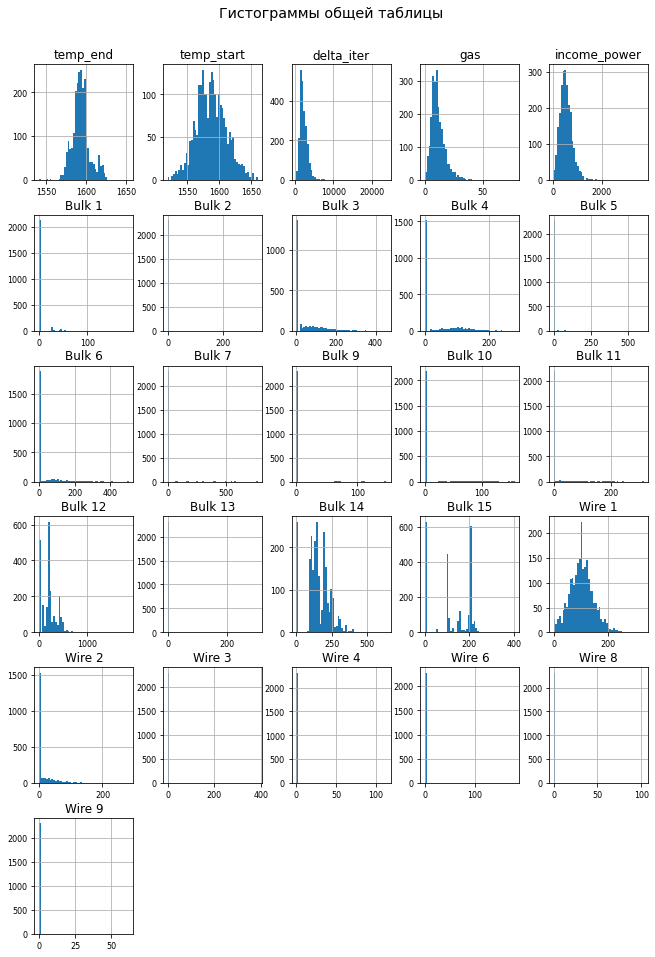

In [35]:
# соединяем датафремы по ключу key:
df = df_temp_fin.merge(df_gas,on='key',how='inner')
df = df.merge(df_energy,on='key',how='inner')
df = df.merge(df_bulk,on='key',how='inner')
df = df.merge(df_wire,on='key',how='inner')
# удаляем столбец с номером партии:
df.drop('key', inplace=True, axis=1)

print(f'Количество строк {df.shape[0]}. Количество колонок {df.shape[1]}.')
df.hist(bins=50,figsize=(11,16),xlabelsize=8,ylabelsize=8)
plt.suptitle('Гистограммы общей таблицы',y=0.93
             , ha='center', fontsize='x-large')
plt.show()

Анализируя графики гистрограм видно, что ряд столбцов имеют большой набор значений, а другие столбцы почти целиком заполнены нулями. Можно предположить, что столбцы с большим числом ненулевых столбцов будут играть решающую роль в прогнозировании конечной температуры. Если закрыть глаза на подачу легирующих элементов, то большинство параметров распределены по нормальному закону распределения. Заметны выбросы в ряде измеренных величин, которые решили не удалять. 

In [36]:
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_end      2325 non-null   float64
 1   temp_start    2325 non-null   float64
 2   delta_iter    2325 non-null   int64  
 3   gas           2325 non-null   float64
 4   income_power  2325 non-null   float64
 5   Bulk 1        2325 non-null   float64
 6   Bulk 2        2325 non-null   float64
 7   Bulk 3        2325 non-null   float64
 8   Bulk 4        2325 non-null   float64
 9   Bulk 5        2325 non-null   float64
 10  Bulk 6        2325 non-null   float64
 11  Bulk 7        2325 non-null   float64
 12  Bulk 9        2325 non-null   float64
 13  Bulk 10       2325 non-null   float64
 14  Bulk 11       2325 non-null   float64
 15  Bulk 12       2325 non-null   float64
 16  Bulk 13       2325 non-null   float64
 17  Bulk 14       2325 non-null   float64
 18  Bulk 15       2325 non-null 

,temp_end,temp_start,delta_iter,gas,income_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 8,Wire 9
0,1613.0,1571.0,1714,29.749986,628.616930,0.0,0.0,0.0,43.0,0.0,...,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,1265,12.555561,395.281800,0.0,0.0,0.0,73.0,0.0,...,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,1753,28.554793,581.774624,0.0,0.0,0.0,34.0,0.0,...,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,1625.0,1601.0,1220,18.841219,543.710274,0.0,0.0,0.0,81.0,0.0,...,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,1536,5.413692,412.180480,0.0,0.0,0.0,78.0,0.0,...,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0


Перед машинным обучением рекомендуется проверить колонки на линейную зависимость между признаками. При наличии линейной зависимости(пусть даже и случайной) между признаками ухудшается сходимость и надежность работы алгоритма из-за того, что матрица для поиска градиента получается с большиим числом обусловленности(близка к вырожденной). Компенсировать это возможно введением регуляризации, но это требует дополнительных трудозатрат. В первую очередь от линейной зависимости признаков страдает модель линейной регрессии. Корреляция почти не влияет на "деревянные" и бустинговые модели. 

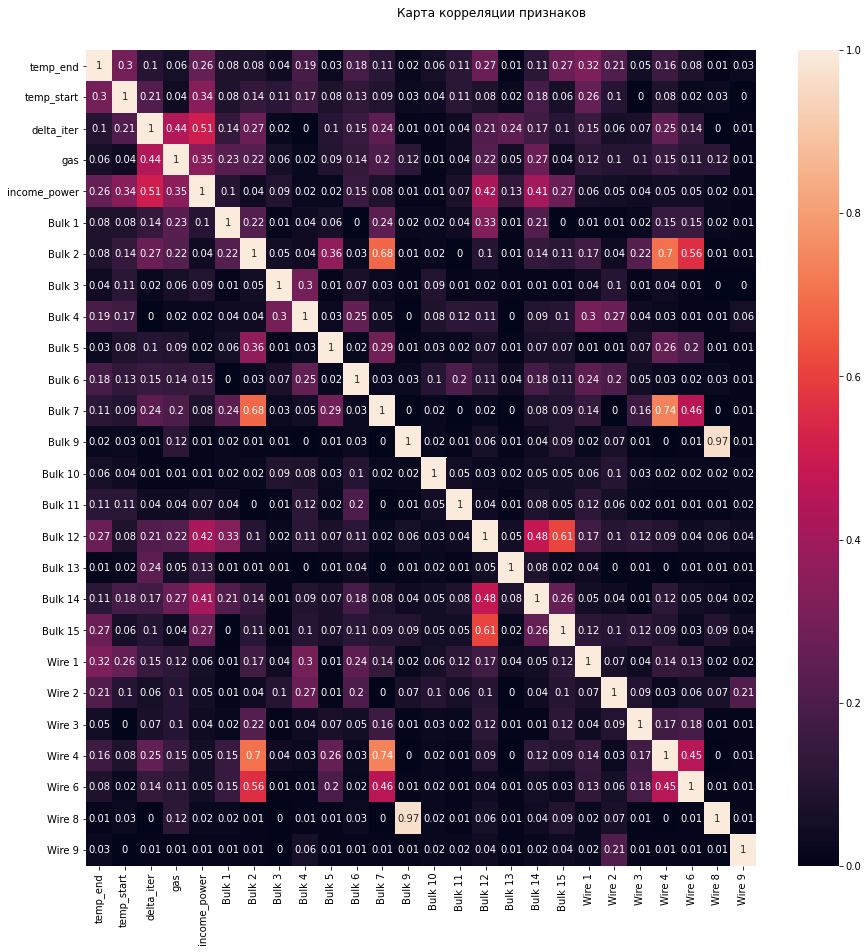

In [37]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(abs(df.corr().round(2)), annot=True, ax=ax)
plt.suptitle('Карта корреляции признаков',y=0.92
             , ha='center', fontsize='large')
plt.show()

Из-за корреляции столбцов Wire 8 и Bulk 9 удалим один из них. 

In [38]:
df.drop(['Wire 8'],axis=1,inplace=True,errors='ignore')
print(f'Количество строк {df.shape[0]}. Количество колонок {df.shape[1]}.')

Количество строк 2325. Количество колонок 25.


### Разделение выборок на признаковую и целевую

Разделим датафрейм на признаковый и целевой. Целевым признаком будет конечная температура. Для оценки качества разделим датафрейм на две части, отделив долю в 25% для тестирования.  

In [39]:
target = df['temp_end']
features = df.drop(['temp_end'],axis=1)

features_train, features_test, target_train,target_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    random_state=rdm)

### Масштабирование признаков

Чтобы улучшить результаты отмасштабируем признаки, перед этим обучив стандартизатор на тренировочных данных. Это в значительной степени актуально для линейной регрессии. 

In [40]:
col_name = features_train.columns
scaler = StandardScaler() #стандартизатор 
scaler.fit(features_train) #обучение стандартизатора
features_train = scaler.transform(features_train) #стандартизация тренировочной выборки
features_test = scaler.transform(features_test) #стандартизация тестовой выборки

features_train = pd.DataFrame(features_train, columns=col_name)
features_test  = pd.DataFrame(features_test, columns=col_name)

## Построение моделей
### Обучение модели lightGBM
Модель lightGBM, использующая принцип градиентного бустинга, хорошо подходит для анализа данных и отличается высокой скоростью. Для подбора лучших параметров используем RandomizedSearchCV, который поможет подобрать параметры и сделает кросс-валидацию. 

In [41]:
gbm = lgb.LGBMRegressor(random_state=rdm) #инициализируем бустинговый регрессор

grid = {'num_leaves': [5, 7, 9],
        'learning_rate': [0.02, 0.04, 0.06],
        'n_estimators':[50,100,150]} #задаем сетку поиска 

rd_gbm = RandomizedSearchCV(estimator=gbm, 
                         param_distributions = grid, 
                         random_state=rdm,
                         cv=5,
                         scoring='neg_mean_absolute_error',
                         n_jobs=-1) 
# обучение:
rd_gbm.fit(features_train, target_train)
#создаем словарь для результатов:
result = {}
result['lightGBM'] = abs( rd_gbm.cv_results_['mean_test_score'][rd_gbm.best_index_])

print(f'Cредний результат lightGBM при кросс-валидации {result.get("lightGBM")}')
#Лучшие параметры модели
print('Лучшие гиперпараметры модели:')
print(rd_gbm.best_params_)

Cредний результат lightGBM при кросс-валидации 6.482236744631433
Лучшие гиперпараметры модели:
{'num_leaves': 9, 'n_estimators': 100, 'learning_rate': 0.04}


### Обучение модели линейной регрессии

Модель линейной регрессии может быть интересной альтернативой градиентному спуску для данной задачи, т.к. такие её слабые стороны как работа с категориальными признаками в данном случае не имеют значения. 

In [42]:
lreg = LinearRegression()
result['Регрессия'] = abs(cross_val_score(lreg, features_train, target_train, 
                             cv=5,scoring='neg_mean_absolute_error').mean() )
print(f'Cредний результат линейной регрессии при кросс-валидации {result.get("Регрессия")}')

Cредний результат линейной регрессии при кросс-валидации 6.530863665313798


### Сравнение с константной моделью
При создании модели за отправную точку берется метрика, которая получена с помощью предсказания постоянным числом для всех случаев. Для метрики MAE лучшей константной моделью является предсказывание медианного значения.   

In [43]:
# создаем константные предсказания
const = [target_train.median()]*len(target_train)
# оцениваем ошибку 
result['const'] = mean_absolute_error(target_train,const)
print(f'Cредний результат константной модели {result.get("const")}')

Cредний результат константной модели 8.036144578313253


### Сравнение моделей


In [44]:
pd.DataFrame.from_dict(result,orient='index',columns=['Результаты'])

,Результаты
lightGBM,6.482237
Регрессия,6.530864
const,8.036145


Лучшие результаты показада модель lightGBM. Модель регрессии лишь немного улучшила результаты константной модели. Результаты, полученные моделью lightGBM отвечают требованиям по достижению метрики MAE ниже 6.8. 

### Тест лучшей модели

Для тестирования лучшей модели возьмем датасет, который ранее отделили от основного датафрейма. Необходимость проверки на тестовом датасете возникает из-за того, чтобы исключить возможность переобучения модели,а так же правильность гиперпараметров.

In [45]:
# лучшая модель:
best_gbm = rd_gbm.best_estimator_

predict = best_gbm.predict(features_test)
mae_test = mean_absolute_error(target_test,predict)
print(f'MAE на тестовой выборке {mae_test}')

r2_test = r2_score(target_test,predict) 
print(f'R2 на тестовой выборке {r2_test}' )

MAE на тестовой выборке 6.688490868494018
R2 на тестовой выборке 0.36889185453892315


Результаты на тестовой выборке оказались несколько хуже, чем при обучении. Это означает, что модель не обладает хорошей обобщающей способностью. Вместе с тем требуемая метрика MAE достигнута. 

Коэффициент R2 показывает, какую долю дисперсии объясняет модель. Чем ближе результат к 1, тем лучше. Значение R2  модели показывает, что имеются возможности для совершенствования. 

### Оценка степени важности признаков
Интересными для анализа предметами является анализ важности признаков в построении модели. Т.к. в основе lightGBM лежит бустинговая модель, в основе которой в свою очередь лежат деревья, то степень важности признаков оценивается двумя способами. По приросту информации - 'gain' и по количеству участий в делении узлов - 'split'.

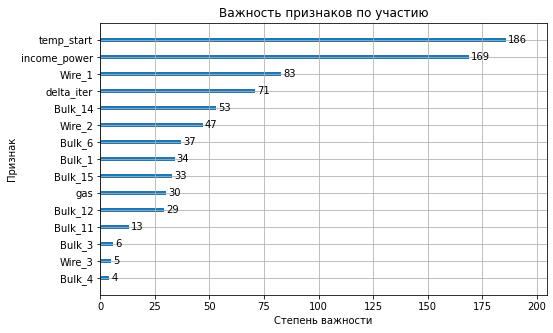

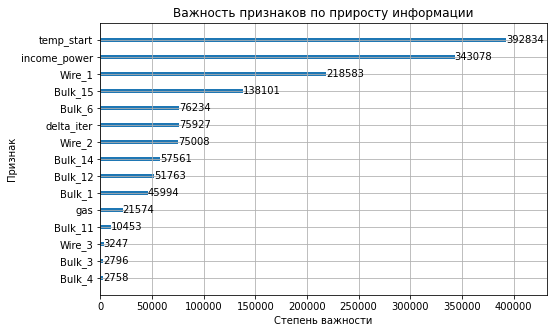

In [46]:
lgb.plot_importance(best_gbm,title='Важность признаков по участию',figsize=(8,5),
                    xlabel='Степень важности',ylabel='Признак',importance_type='split')
lgb.plot_importance(best_gbm,title='Важность признаков по приросту информации',figsize=(8,5),
                    xlabel='Степень важности',ylabel='Признак',importance_type='gain',
                   precision=0);                   

Чем выше значение, тем сильнее признак влияет на результат. Максимальное влияние начальной температуры вполне объяснимо, второй по важности признак - мощность нагревателей.  

### Итоги построения модели
В ходе работ была проведена предварительная обработка датасетов. Произведена модификация признаков, в результате чего получены новые признаки. Разрозненные таблицы были сведены в одну, после чего сделана финальная проверка и корректировка финального датасета. 

На основе датасета построены модели lightGBM и линейной регрессии. Полученные lightGBM результаты удовлетворяют требованиям. Обе модели показывают результаты лучше константной модели. 

На тестовой выборке лучшей моделью lightGBM получен высокий результат, превышающий требования задания. 

# Отчет
## Постановка задачи и описание
Во время процесса изготовления стали используется её нагрев до высоких температур(свыше 1450 град.), что требует большого потребления электричества. В целях снижения издержек для предприятия необходима модель прогнозирования конечной температуры стали. Сложность создания модели заключается в том, что помимо самого процесса нагрева стали, происходит добавление легирующих элементов из бункеров и в виде проволоки. Перемешивание и защита расплава происходит продувкой инертными газами. Таким образом 

## План

После разведывательного анализа данных был составлен предварительный план:
1. Очистить таблицы от выбросов и аномалий,заполнить пропуски, привести данные к нужному типу. 
2. Провести слияние таблиц в одну большую таблицу по ключу или по дате.
3. Добавить столбцы, которые сигнализируют о начале операции легирования. Например, если в 15:20 добавили проволоку, то с этого времени и до окончания итерации справочный столбец имеет значение 1. До этого времени значение столбца равно 0. И так по каждой итерации. 
4. Далее попробовать два варианта. Первый вариант подразумевает стационарность процессов. Второй вариант подразумевает применение модели временных рядов или скользящего среднего. После этого соответственно удалить столбцы с ключом или/и временем.
5. Разделить датасет, выделив целевую величину - температуру стали. 
6. Опробовать модель lightGBM, которая должна лучше всего подойти для этой задачи. 
7. Протестировать модель на тестовой и валидационной выборке. Метрика MSE предпочтительна.

После консультации и изучения новых вводных план был значительно скорректирован. Получены следующие требования:
1. Могут быть удалены только явные выбросы, нарушающие законы физики. 
2. Партии, где имеются замеры температуры с пропусками или ниже 1450 град., должны быть целиком удалены.
3. В качестве признака известна только первая измеренная температура. 
4. Модель должна обеспечивать метрику МАЕ<=6.8
5. Должно быть минимум три модели - одна с автоматизированным подбором параметров, одна альтернативная, еще одна константная. Модели должны обучаться с применением метода кросс-валидации. 
6. Доля данных тестовой выборки - 25%. 
7. Random_state установлен на 80523. 

Итоговый план был значительно скорректирован и выглядит следующим образом:
1. Подготовка датасетов: преобразование данных, выделение признаков, создание новых признаков на базе имеющихся. 
2. Объединение датасетов в один сводный. 
3. Анализ сводного датасета, его разделение на признаковый и целевой, тренировочный и тестовый.
4. Обучение стандартизатора на тренировочном датасете с последующей нормализацией значений всех выборок.
5. Обучение модели lightGBM и оценка её результатов.
6. Обучение модели линейной регрессии и оценка её результатов.
7. Получение результатов константой модели. 
8. Анализ важности признаков

Корректировка плана произошла после консультации вследствие получения уточняющей информации. 

## Трудности проекта
Трудностью в проекте является большое количество датасетов, которые требуется соответствующим образом свести в итоговый. Сложностью при выполнении проекта является тот факт, что колебание температуры происходит в очень незначительном коридоре значений. Межквартильный размах значений не превышает 20 град. Помимо технически сложного замера температуры стали, которая имеет температуру 1500 град., требуется обеспечить высокую точность измерений. Согласно открытым источникам погрешность измерения стали составляет 4 градуса, что является существенным возмущающим фактором в точность модели. 


## Ключевые шаги решения

При выполнении проекта выполнен большой объем работ. Далее приведено краткое описание работ.

### Подготовка данных
Для построения модели предоставлены основные данные:
- время и мощность включения нагревателей
- время и объем легирующих элементов из бункера
- время и количество проволочных легирующих элементов
- время замера и температура стали
- расход газа

Согласно требованиям произведено удаление явных выбросов и аномалий в данных. Заполнение пропусков нулями в таблицах о подаче легирующих элементов или удаление записей целиком в случае с температурой. Данные по мощности и температуре сгруппированы по ключу с помощью механизма сводных таблиц. Вместо мощности и времени работы нагревателя используется обобщенная характеристика в виде суммы активной энергии, вложенной в расплав. Добавлено общее время выплавки стали, вычисленное по результатам первого и последнего замера температуры стали. 

Из отдельных таблиц сформирован общий датасет, состоящий из данных о температуре, мощности и объеме подачи легирующих элементов. В окончательный датасет не вошли данные о времени подачи легирующих элементов. В результирующий датасет попали только данные, отвечающие требованиям проекта и информация о которых имеется во всех таблицах. 

Для снижения размерности задачи и повышения надежности решения проведен анализ признаков на корреляцию значений. Столбец 'wire 8' был удален из-за сильной корреляции с столбцом 'bulk 9'. 

Данные разделены на признаковую и целевую части. Целевым значением выступает последняя температура партии. Затем данные разделены на обучающую и тестовую выборки. Обучающая выборка используется для создания модели, а тестовая выборка показывает, как модель будет вести себя с новыми данными.  Некоторые модели лучше работают, если данные нормализованы. Для этого на обучающей выборке обучен стандартизатор, после чего он применен к обработке датасетов. 

### Обучение моделей, тестирование,метрики
На основе подготовленных данных обучена бустинговая модель фреймворка lightGBM. Параметры модели автоматически подбирались механизмом RandomSearchCV. Получены следующие лучшие параметры модели: 'num_leaves': 9, 'n_estimators': 100, 'learning_rate': 0.04, 'random_state': 80523. В процессе работы происходит кросс-валидация по 5 блокам. Итоговый средний результат  метрики MAE удовлетворяет требованиям задачи и составляет около 6.5. 

В качестве альтернативной модели взята модель линейной регрессии. Значимых гиперпараметров в ней не имеется, но результат так же удовлетворяет требованиям и составляет около 6.5. 

Для оценки эффективности работы обучающихся моделей взята константная модель, которая всегда предсказывает одно и тоже число. Для метрики MAE наилучшим предсказанием является медианное значение, для которого получена метрика МАЕ 

Для окончательного тестирования выбрана модель lightGBM, которая на тестовых данных показала метрику 6.7. Это удовлетворяет требованиям задания. Дополнительно проанализирована метрика R2, которая показывает качество модели. Идеальная модель имеет показатель 1, константная 0. Результат составил 0.37, что показывает наличие резервов для улучшения модели. 

Интересными для анализа являются диаграммы важности признаков. Чем важнее признак, тем чаще он участвует в построении модели ('split') или дает наибольший прирост информации ('gain'). Самыми важными признаками оказалась начальная температура, вложенная энергия и объем подачи проволоки Wire 1. 

## Рекомендации по улучшению модели
Улучшение модели можно достичь с помощью увеличения объема информации, которое получено со стороны завода. Некоторого улучшения можно добиться, если отбирать лучшие признаки и удалять малозначимые. 


## Итог
Полученные модели отвечают требованиям задания и могут успешно применяться для предсказания температуры. 
